### Membres du groupe : 
Mehdi Ben Salha - Wissem Yousfi - Yassine Dhaouadi - Zakaria Soussi

<br>
<br>

The Pavia University scene is a hyperspectral dataset collected by the ROSIS, over an agricultural area in Pavia, Italy. It is commonly used to categorize land cover and remote sensing research. The dataset consists of 610 rows and 340 columns, with 103 spectral bands altogether. Each pixel in the dataset represents a 1.3x1.3-meter area on the ground. The Pavia University scene dataset contains nine different classes of land cover, including various types of crops, bare soil, and meadows.  The dataset also includes ground truth maps that indicate the true class labels for each pixel in the image.
| No.  | Class                  | Samples |
|------|------------------------|---------|
| 1.   | Asphalt                | 6631    |
| 2.   | Meadows                | 18649   |
| 3.   | Gravel                 | 2099    |
| 4.   | Trees                  | 3064    |
| 5.   | Painted metal sheets   | 1345    |
| 6.   | Bare Soil              | 5029    |
| 7.   | Bitumen                | 1330    |
| 8.   | Self-Blocking Bricks   | 3682    |
| 9.   | Shadows                | 947     |




In [2]:
#imports
import urllib.request
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import earthpy.plot as ep
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
import plotly.graph_objects as go
from keras.layers import  Flatten, Dense, Reshape, BatchNormalization
from keras.models import Model


# Ignore all warnings
warnings.filterwarnings("ignore")


### Download The Pavia University Dataset

In [126]:

# Download PaviaU.mat
#urllib.request.urlretrieve("https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat", "PaviaU.mat")

# Download PaviaU_gt.mat
#urllib.request.urlretrieve("https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat", "PaviaU_gt.mat")


**PaviaU.mat** - The data set in .mat format

**PaviaU_gt.mat** - The ground truth of the dataset in .mat format

### Load the Data

In [3]:
# Load the .mat files
data = loadmat('PaviaU.mat')['paviaU']
gt = loadmat('PaviaU_gt.mat')['paviaU_gt']


In [4]:
#The dimensions of the data.
print(f'Dataset: {data.shape}\nGround Truth: {gt.shape}')

Dataset: (610, 340, 103)
Ground Truth: (610, 340)


### Visualize the image


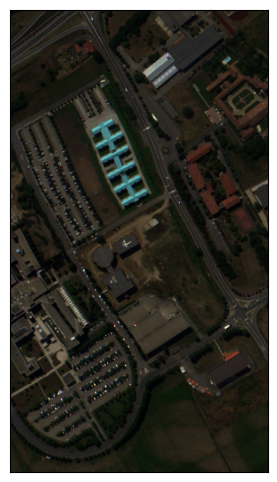

In [5]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(arr = mdata, rgb = (52, 30, 10),figsize=(6,6)) # Plotting the RGB image

plt.show()

### Visualize some random bands

In [6]:
def plot_band(dataset):
    #plot a 2*2 grid of random bands from the dataset with a colorbar 
    fig, axs = plt.subplots(2, 2, figsize=(7, 5))
    for i in range(2):
        for j in range(2):
            band = np.random.randint(0, dataset.shape[2])
            axs[i, j].imshow(dataset[:, :, band], cmap='nipy_spectral')
            axs[i, j].set_title(f'Band {band}')
            axs[i, j].axis('off')
    plt.colorbar(axs[1, 1].imshow(dataset[:, :, band], cmap='nipy_spectral'), ax=axs, orientation='vertical')
    plt.show()
    

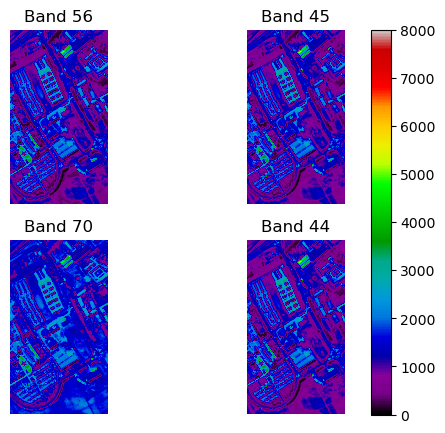

In [7]:
plot_band(data)

### Visualize the ground truth of the image

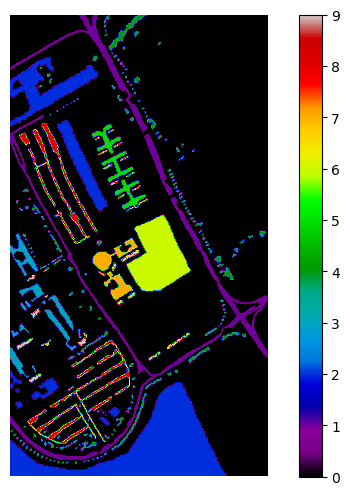

In [8]:
plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(ticks= range(0,10))
plt.show()

### Data Extraction


In [9]:
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [10]:
df = extract_pixels(data, gt)
df

  0%|          | 0/103 [00:00<?, ?it/s]

100%|██████████| 103/103 [00:01<00:00, 71.71it/s]


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-95,band-96,band-97,band-98,band-99,band-100,band-101,band-102,band-103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,574,594,504,411,468,443,378,342,352,434,...,2150,2157,2157,2169,2151,2108,2077,2076,2136,0
207396,485,644,709,582,504,494,434,373,391,421,...,2264,2295,2282,2265,2275,2293,2274,2274,2258,0
207397,593,387,428,461,470,392,331,383,439,355,...,2393,2407,2433,2413,2373,2389,2382,2407,2423,0
207398,593,751,655,458,503,560,482,412,404,454,...,2340,2333,2332,2288,2251,2280,2312,2308,2289,0


In [11]:
classes = {
    0: 'Background',
    1: 'Asphalt',
    2: 'Meadows',
    3: 'Gravel',
    4: 'Trees',
    5: 'Painted metal sheets',
    6: 'Bare Soil',
    7: 'Bitumen',
    8: 'Self-Blocking Bricks',
    9: 'Shadows'
}


### Save the dataset in CSV format

In [136]:
df.to_csv('Dataset.csv', index=False)

### Visualizing spectral signatures


In [12]:
def plot_signature(df,pixel_no=-1):
    if pixel_no == -1:
        pixel_no = np.random.randint(0, df.shape[0])
    plt.figure(figsize=(10, 2))
    plt.plot(range(1, df.shape[1]), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]} {classes[df.iloc[pixel_no, -1]]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

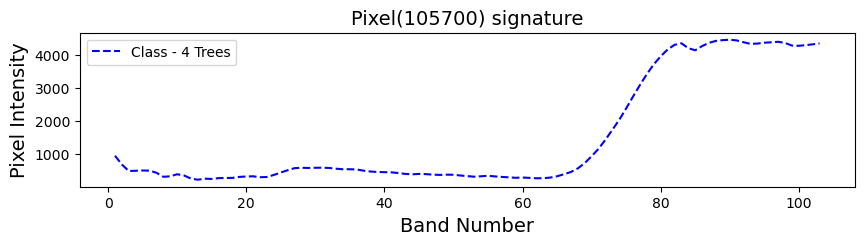

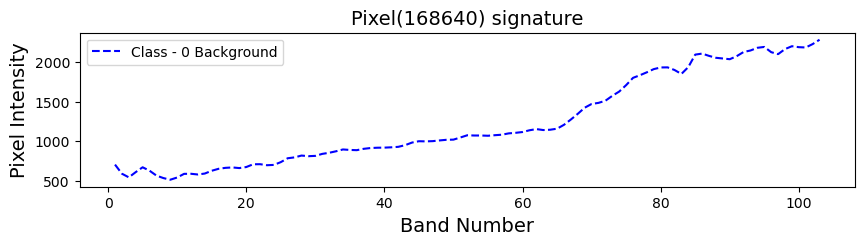

In [13]:
plot_signature(df,105700)
plot_signature(df)

### Average Signature of Different Classes

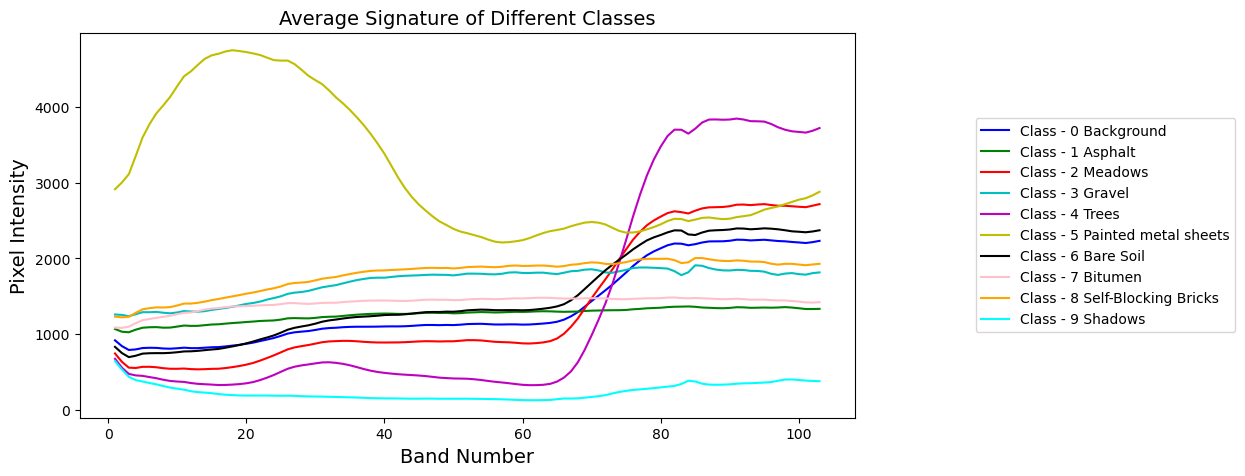

In [14]:
#plot different classes signature
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'cyan']
plt.figure(figsize=(10, 5))
for i in range(0, 10):
    plt.plot(range(1, df.shape[1]), df[df['class']==i].mean()[:-1].values.tolist(), label=f'Class - {i} {classes[i]}',color=colors[i])
plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5))
plt.title('Average Signature of Different Classes', fontsize=14)
plt.xlabel('Band Number', fontsize=14)
plt.ylabel('Pixel Intensity', fontsize=14)
plt.show()


### Class Distribution

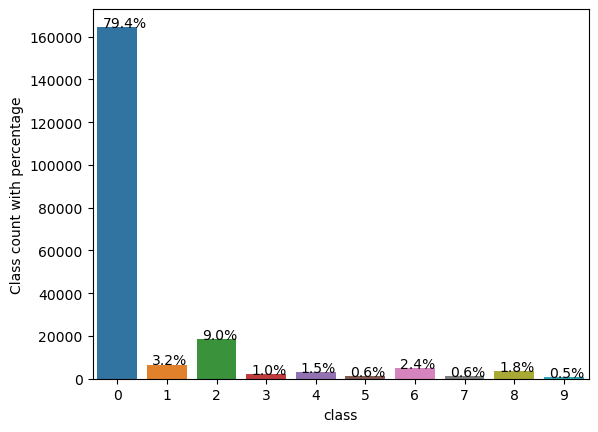

In [140]:

ax = sns.countplot(x='class', data=df[['class']])

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))

plt.ylabel('Class count with percentage')

plt.xlabel('class')


plt.show()

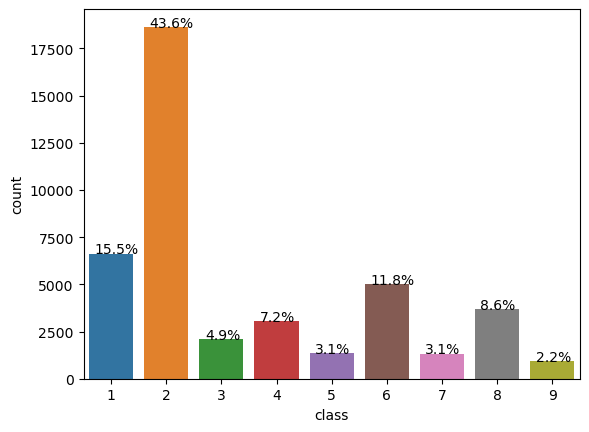

In [278]:
#class distrib after removing 0

ax = sns.countplot(x='class', data=df[['class']][df['class']!=0])
#add percentage to the plot

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df[['class']][df['class']!=0].shape[0]), (p.get_x()+0.1, p.get_height()+5))
                

### Remove the class 0 and creating a train test split

In [15]:
X = df[df['class']!=0].iloc[:, :-1].values

y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 

#scaling
scaler = StandardScaler()

X = scaler.fit_transform(X)




In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y)



### Principal Component Analysis

In [17]:
def apply_pca(X, n_components):
    pca = PCA(n_components = n_components)

    principalComponents = pca.fit_transform(X)

    principalDf = pd.DataFrame(data = principalComponents, columns = [f'principal component {i}' for i in range(1, n_components+1)])

    ev=pca.explained_variance_ratio_

    return principalDf,ev


In [18]:
predictX,ev=apply_pca(X,20)

In [19]:
#train test

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(predictX, y, train_size = 0.8, stratify = y)

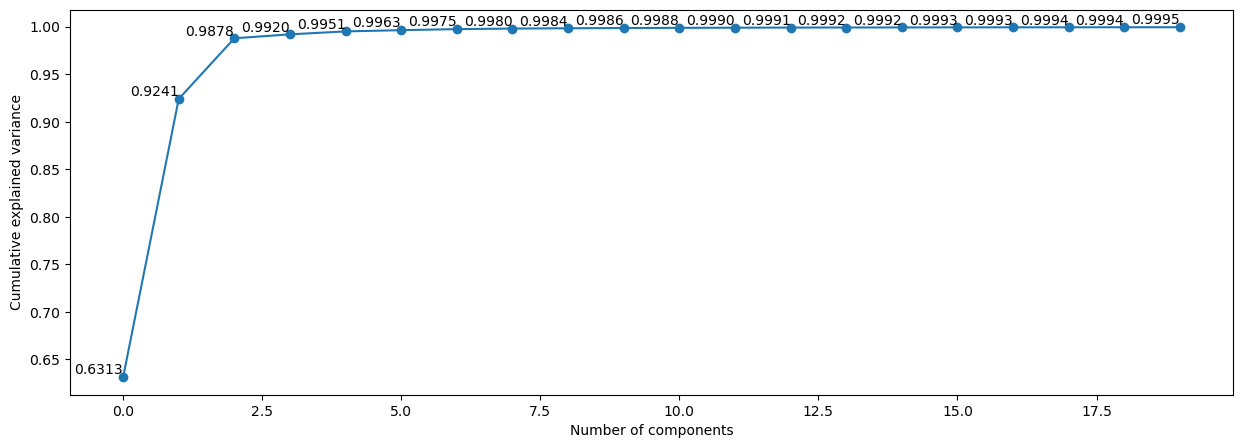

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(ev.cumsum(), marker='o', linestyle='-')

# Annotate the plot with the values
for i, value in enumerate(ev.cumsum()):
    if(i%1==0):
        plt.text(i, value, f'{value:.4f}', ha='right', va='bottom')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Artificial Neural Network

In [21]:

model = Sequential(name='Pavia_University')

model.add(Input(shape = X_train[0].shape, name = 'Input_Layer'))

model.add(BatchNormalization(name = 'BatchNormalization'))

model.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))

model.add(Dropout(rate = 0.2, name = 'Dropout1',))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))

model.add(Dropout(rate = 0.2, name = 'Dropout2'))

model.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))

model.add(Dense(units = y_train.shape[1], activation= 'softmax', name = 'Output_Layer'))

model.summary()


Model: "Pavia_University"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchN  (None, 103)               412       
 ormalization)                                                   
                                                                 
 Layer1 (Dense)              (None, 128)               13312     
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                                 

In [22]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x = X_train, 
          y = y_train,
          validation_data = (X_test, y_test), 
          epochs = 100,
          callbacks = [es, checkpoint])


Epoch 1/100


1061/1070 [============================>.] - ETA: 0s - loss: 0.8510 - accuracy: 0.6817
Epoch 1: val_loss improved from inf to 0.52250, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 8s 5ms/step - loss: 0.8492 - accuracy: 0.6826 - val_loss: 0.5225 - val_accuracy: 0.7846
Epoch 2/100
1058/1070 [============================>.] - ETA: 0s - loss: 0.5672 - accuracy: 0.7858
Epoch 2: val_loss improved from 0.52250 to 0.42097, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 5s 4ms/step - loss: 0.5661 - accuracy: 0.7861 - val_loss: 0.4210 - val_accuracy: 0.8339
Epoch 3/100
1070/1070 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8120
Epoch 3: val_loss improved from 0.42097 to 0.35082, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 5s 4ms/step - loss: 0.4952 - accuracy: 0.8120 - val_loss: 0.3508 - val_accuracy: 0.8573
Epoch 4/100
1064/1070 [

In [27]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

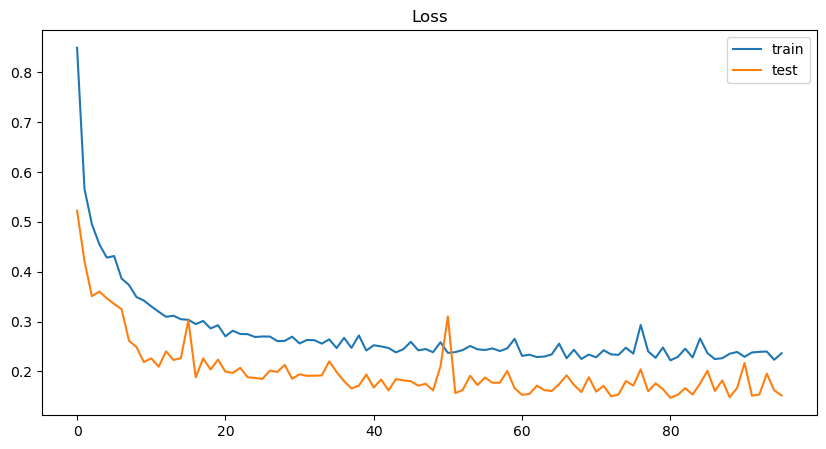

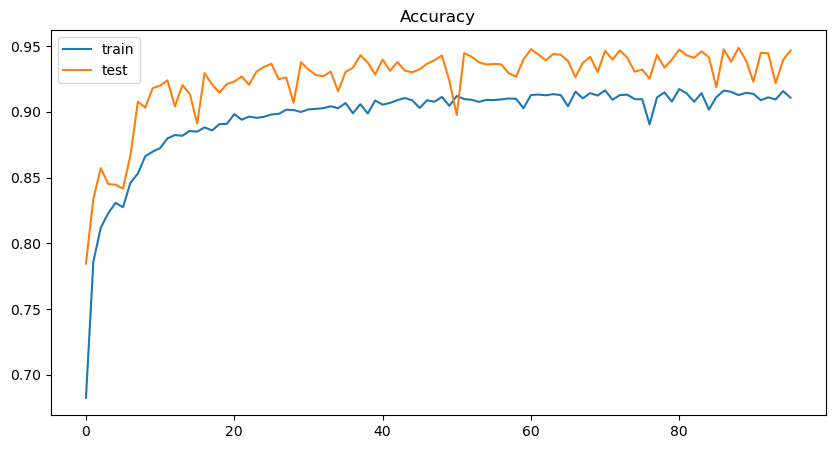

In [28]:
plot_history(history)

In [29]:
from sklearn.metrics import classification_report


pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']))

268/268 [==============================] - 1s 2ms/step
                         precision    recall  f1-score   support

             1. Asphalt       0.93      0.97      0.95      1264
             2. Meadows       0.99      0.97      0.98      3817
              3. Gravel       0.77      0.85      0.81       384
               4. Trees       0.96      0.96      0.96       611
5. Painted metal sheets       1.00      1.00      1.00       269
           6. Bare Soil       0.90      0.97      0.94       929
             7. Bitumen       0.89      0.84      0.86       280
8. Self-Blocking Bricks       0.92      0.83      0.87       813
             9. Shadows       1.00      1.00      1.00       189

               accuracy                           0.95      8556
              macro avg       0.93      0.93      0.93      8556
           weighted avg       0.95      0.95      0.95      8556



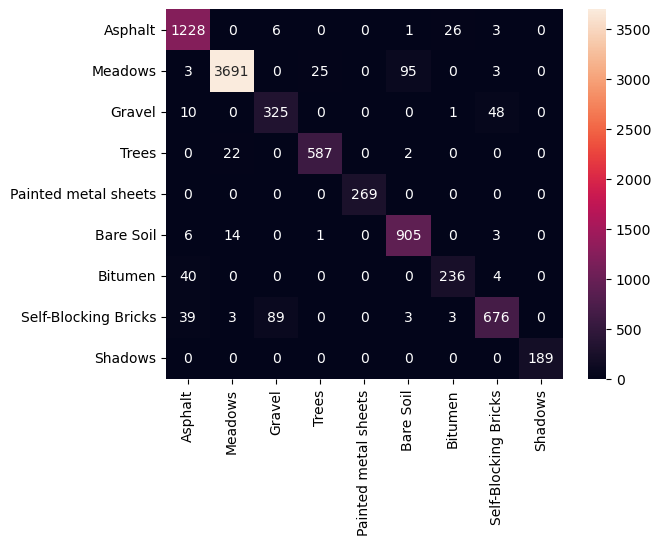

In [30]:

from sklearn.metrics import confusion_matrix


classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [31]:
#get predictions for all the pixels
dd=model.predict(scaler.transform(df.iloc[:, :-1].values))

# create a mask for class == 0
mask = df['class'] == 0

dd[mask] = 0

6482/6482 [==============================] - 13s 2ms/step


In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [33]:
def plot_prediction_gt(dd):

    # Plot predictions and ground truth side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Plot predictions
    pred_im = axes[0].imshow(np.argmax(dd, axis=1).reshape(610, 340), cmap='nipy_spectral')
    axes[0].axis('off')
    axes[0].set_title('Predictions')
    cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

    # Plot ground truth
    gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
    axes[1].axis('off')
    axes[1].set_title('Ground Truth')
    cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

    plt.show()


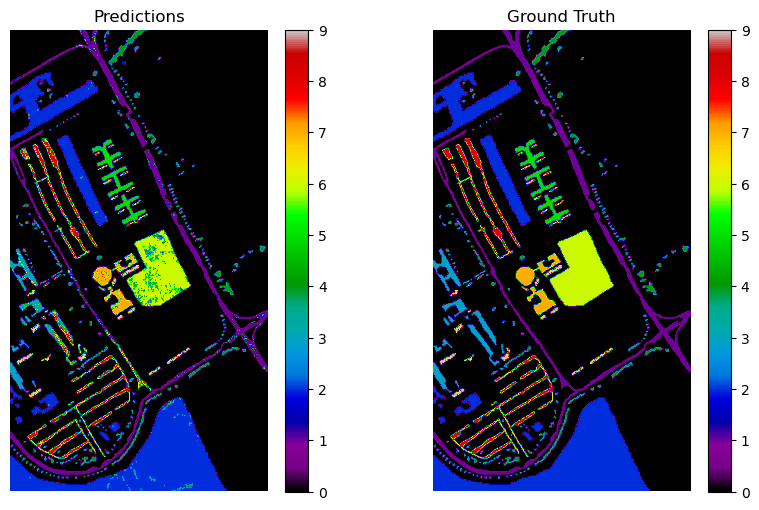

In [34]:
plot_prediction_gt(dd)

In [35]:
scaled_data = scaler.transform(df.iloc[:, :-1].values)


In [36]:

model_pca = Sequential(name='Pavia_University_PCA')

model_pca.add(Input(shape = X_train_pca.iloc[0].shape, name = 'Input_Layer'))

model_pca.add(BatchNormalization(name = 'BatchNormalization'))

model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))
model_pca.add(Dropout(rate = 0.2, name = 'Dropout1',))

model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))
model_pca.add(Dropout(rate = 0.2, name = 'Dropout2'))

model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))


model_pca.add(Dense(units = y_train.shape[1], activation= 'softmax', name = 'Output_Layer'))

model_pca.summary()

Model: "Pavia_University_PCA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchN  (None, 20)                80        
 ormalization)                                                   
                                                                 
 Layer1 (Dense)              (None, 128)               2688      
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                              

In [39]:
# fit with pdf

model_pca.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 8,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model_pca.fit(x = X_train_pca, 
          y = y_train_pca,
          validation_data = (X_test_pca, y_test_pca),
          epochs = 100,
          callbacks = [es, checkpoint])

Epoch 1/100
1060/1070 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8717
Epoch 1: val_loss improved from inf to 0.19702, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 8s 4ms/step - loss: 0.3392 - accuracy: 0.8719 - val_loss: 0.1970 - val_accuracy: 0.9285
Epoch 2/100
1059/1070 [============================>.] - ETA: 0s - loss: 0.2736 - accuracy: 0.9058
Epoch 2: val_loss improved from 0.19702 to 0.19095, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 5s 4ms/step - loss: 0.2736 - accuracy: 0.9058 - val_loss: 0.1909 - val_accuracy: 0.9322
Epoch 3/100
1065/1070 [============================>.] - ETA: 0s - loss: 0.2551 - accuracy: 0.9105
Epoch 3: val_loss improved from 0.19095 to 0.17764, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 5s 4ms/step - loss: 0.2547 - accuracy: 0.9107 - val_loss: 0.1776 - val_accuracy: 0.9386
Epoch 4/100
1069/1070 [===

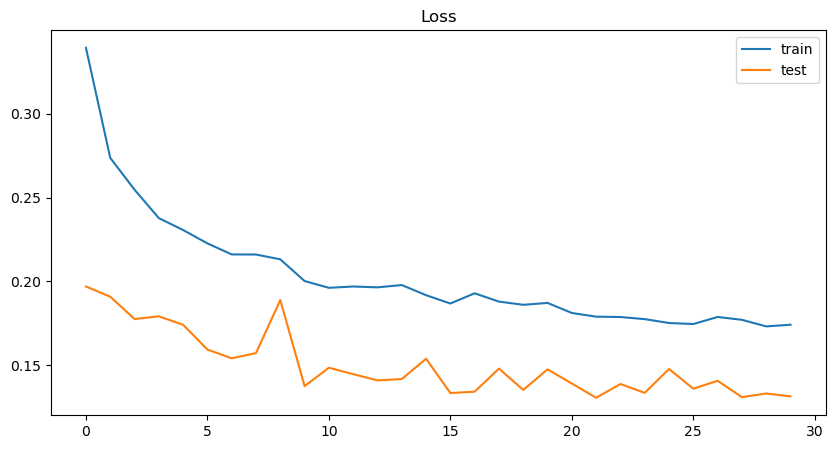

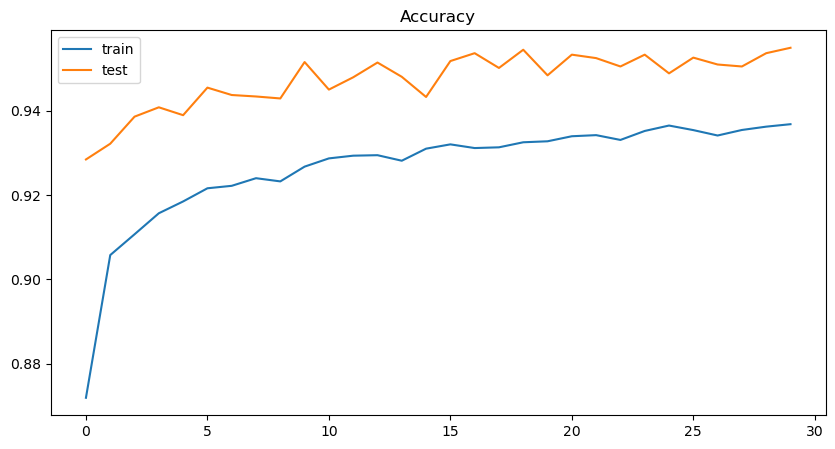

In [40]:
plot_history(history)

In [41]:


predd = np.argmax(model_pca.predict(X_test_pca), axis=1)

# Classification Report
print(classification_report(predd, np.argmax(y_test_pca, 1),
      target_names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']))

268/268 [==============================] - 1s 2ms/step
                         precision    recall  f1-score   support

             1. Asphalt       0.97      0.95      0.96      1341
             2. Meadows       0.98      0.98      0.98      3761
              3. Gravel       0.76      0.86      0.81       370
               4. Trees       0.98      0.94      0.96       640
5. Painted metal sheets       1.00      1.00      1.00       269
           6. Bare Soil       0.91      0.96      0.94       955
             7. Bitumen       0.90      0.94      0.92       254
8. Self-Blocking Bricks       0.90      0.85      0.87       777
             9. Shadows       1.00      1.00      1.00       189

               accuracy                           0.95      8556
              macro avg       0.93      0.94      0.94      8556
           weighted avg       0.95      0.95      0.95      8556



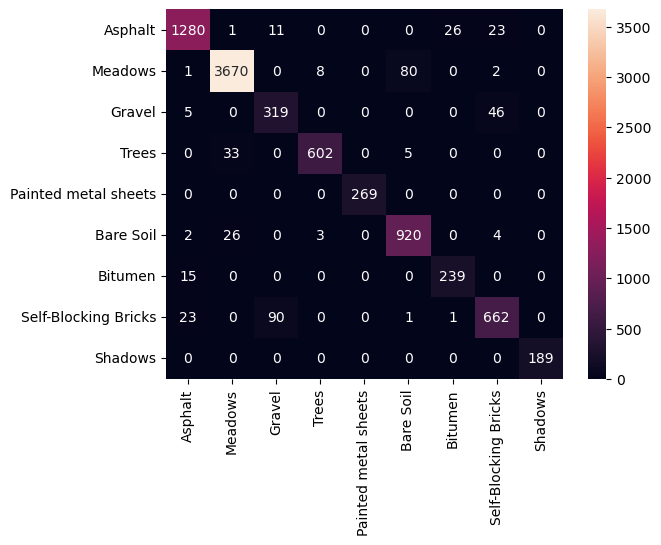

In [42]:

from sklearn.metrics import confusion_matrix


classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

mat = confusion_matrix(np.add(predd, 1), np.add(np.argmax(y_test_pca, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [43]:
def generate_image_from_pred(pred, gt):
    img = gt.copy()
    k=0
    index = 0
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
           
            if gt[i][j]==0:
                k+=1
                img[i][j] = 0  
                continue
            else:
                img[i][j] = pred[index]
                index+=1
    print(index)     
    return img

In [44]:
dd=model_pca.predict(predictX)



1337/1337 [==============================] - 2s 2ms/step


In [45]:
img=generate_image_from_pred(np.argmax(dd, axis=1), gt)

42776


In [47]:
def plot_pred(img):
    # Plot predictions and ground truth side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Plot predictions
    pred_im = axes[0].imshow(img, cmap='nipy_spectral')
    axes[0].axis('off')
    axes[0].set_title('Predictions')
    cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

    # Plot ground truth
    gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
    axes[1].axis('off')
    axes[1].set_title('Ground Truth')
    cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

    plt.show()

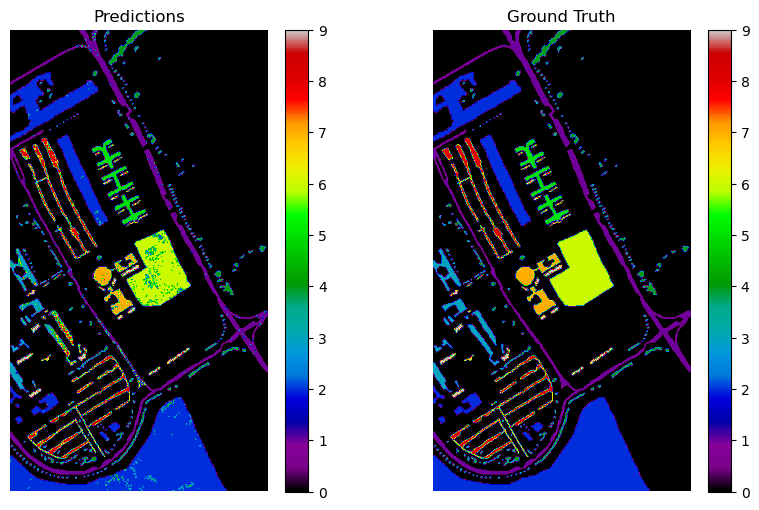

In [48]:
plot_pred(img)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(img.ravel(), gt.ravel(), target_names = classes.append('Background')))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       0.97      0.96      0.97      6694
           2       0.99      0.98      0.98     18793
           3       0.77      0.89      0.83      1808
           4       0.99      0.95      0.97      3183
           5       1.00      1.00      1.00      1345
           6       0.93      0.98      0.95      4774
           7       0.91      0.93      0.92      1307
           8       0.92      0.86      0.89      3927
           9       1.00      1.00      1.00       945

    accuracy                           0.99    207400
   macro avg       0.95      0.96      0.95    207400
weighted avg       0.99      0.99      0.99    207400



### KNN


In [387]:
#implement knn with k=8 but the neighbours are actually the 8 pixels that are around the pixel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#reshape the data

#scale all df
scaler = StandardScaler()
XX = scaler.fit_transform(df.iloc[:, :-1].values)
yy=df['class'].values
#make the model
from sklearn.metrics import f1_score


def knn(k):
    knn = KNeighborsClassifier(n_neighbors=k)

    #fit the model
    knn.fit(XX,yy)



    #plot the predictions
    pred = knn.predict(XX)

    

    pred = pred.reshape(610, 340)

    # Plot predictions and ground truth side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Plot predictions
    pred_im = axes[0].imshow(pred, cmap='nipy_spectral')
    axes[0].axis('off')
    axes[0].set_title(f'Predictions with {k} neighbours')
    cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

    # Plot ground truth
    gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
    axes[1].axis('off')
    axes[1].set_title('Ground Truth')
    cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

    plt.show()
  
    return pred







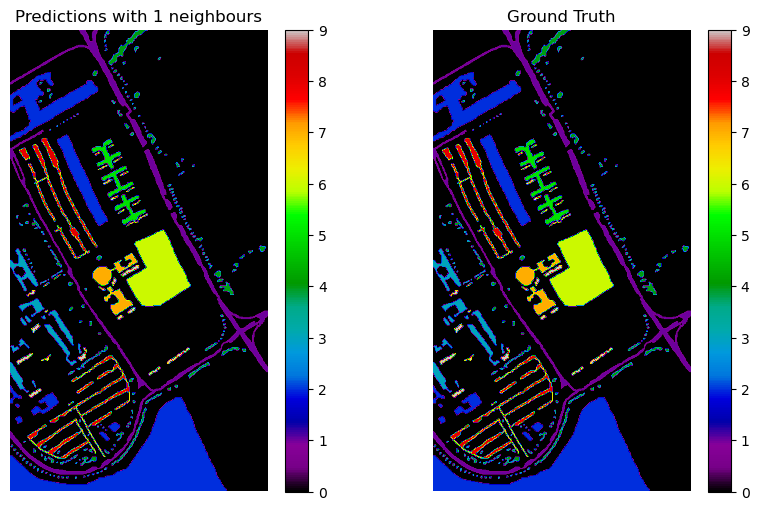

Classification Report with 1 neighbours:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       1.00      1.00      1.00      6631
           2       1.00      1.00      1.00     18649
           3       1.00      1.00      1.00      2099
           4       1.00      1.00      1.00      3064
           5       1.00      1.00      1.00      1345
           6       1.00      1.00      1.00      5029
           7       1.00      1.00      1.00      1330
           8       1.00      1.00      1.00      3682
           9       1.00      1.00      1.00       947

    accuracy                           1.00    207400
   macro avg       1.00      1.00      1.00    207400
weighted avg       1.00      1.00      1.00    207400



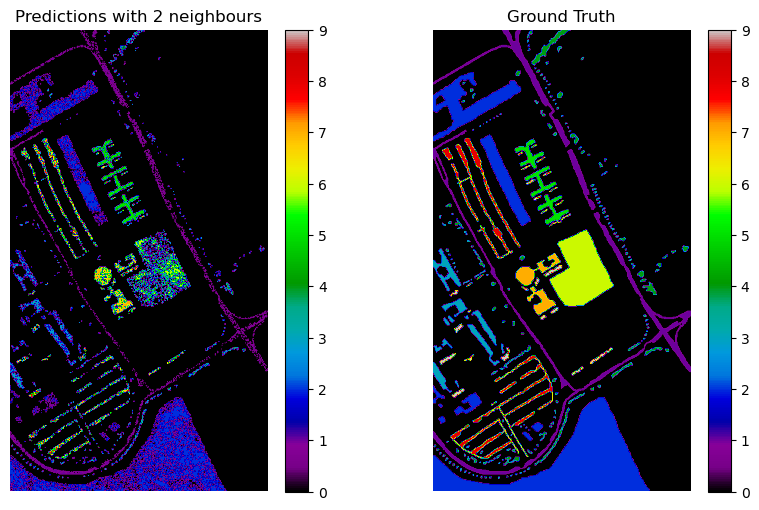

Classification Report with 2 neighbours:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    164624
           1       0.96      0.47      0.63      6631
           2       0.96      0.64      0.77     18649
           3       0.85      0.54      0.66      2099
           4       1.00      0.33      0.50      3064
           5       1.00      0.82      0.90      1345
           6       1.00      0.32      0.48      5029
           7       1.00      0.63      0.77      1330
           8       1.00      0.44      0.62      3682
           9       1.00      0.41      0.58       947

    accuracy                           0.90    207400
   macro avg       0.97      0.56      0.69    207400
weighted avg       0.91      0.90      0.89    207400



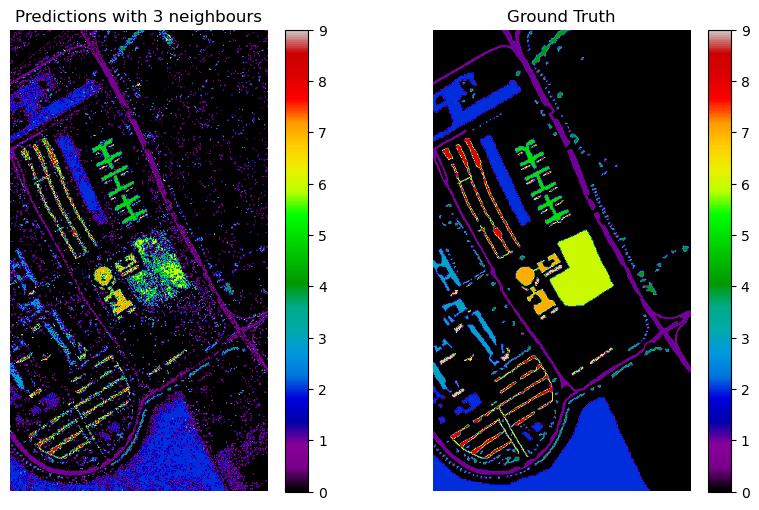

Classification Report with 3 neighbours:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    164624
           1       0.78      0.62      0.69      6631
           2       0.79      0.80      0.80     18649
           3       0.79      0.62      0.69      2099
           4       0.78      0.51      0.61      3064
           5       0.89      0.93      0.91      1345
           6       0.77      0.47      0.58      5029
           7       0.78      0.78      0.78      1330
           8       0.74      0.64      0.68      3682
           9       0.77      0.63      0.69       947

    accuracy                           0.90    207400
   macro avg       0.80      0.69      0.74    207400
weighted avg       0.90      0.90      0.90    207400



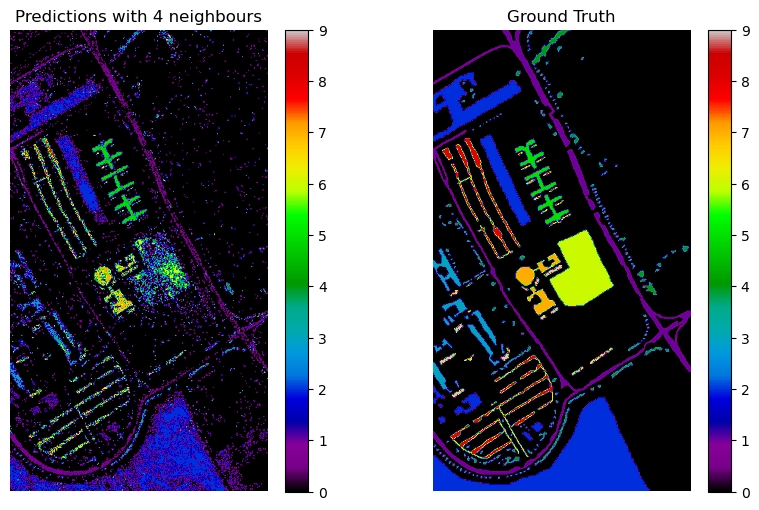

Classification Report with 4 neighbours:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    164624
           1       0.83      0.43      0.57      6631
           2       0.83      0.65      0.73     18649
           3       0.75      0.49      0.60      2099
           4       0.82      0.27      0.41      3064
           5       0.92      0.86      0.89      1345
           6       0.78      0.31      0.45      5029
           7       0.78      0.71      0.74      1330
           8       0.76      0.48      0.59      3682
           9       0.82      0.36      0.50       947

    accuracy                           0.88    207400
   macro avg       0.82      0.55      0.64    207400
weighted avg       0.88      0.88      0.87    207400



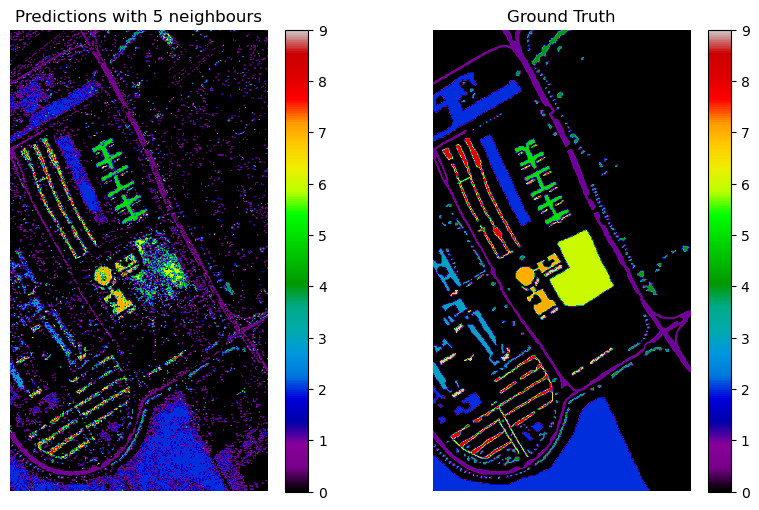

Classification Report with 5 neighbours:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    164624
           1       0.74      0.53      0.62      6631
           2       0.75      0.75      0.75     18649
           3       0.73      0.52      0.61      2099
           4       0.74      0.36      0.49      3064
           5       0.86      0.91      0.89      1345
           6       0.73      0.33      0.46      5029
           7       0.75      0.75      0.75      1330
           8       0.70      0.56      0.62      3682
           9       0.72      0.51      0.60       947

    accuracy                           0.88    207400
   macro avg       0.76      0.62      0.67    207400
weighted avg       0.87      0.88      0.87    207400



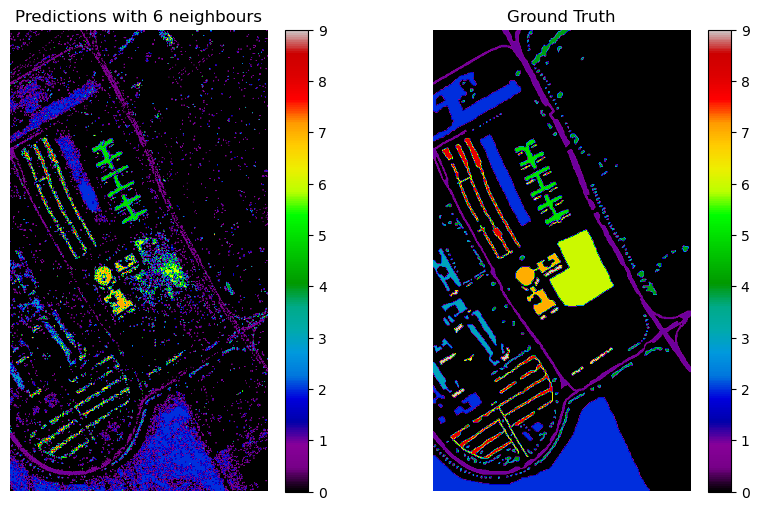

Classification Report with 6 neighbours:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    164624
           1       0.78      0.41      0.54      6631
           2       0.79      0.65      0.71     18649
           3       0.75      0.45      0.56      2099
           4       0.80      0.24      0.37      3064
           5       0.88      0.87      0.88      1345
           6       0.76      0.27      0.40      5029
           7       0.74      0.72      0.73      1330
           8       0.70      0.47      0.56      3682
           9       0.75      0.33      0.46       947

    accuracy                           0.87    207400
   macro avg       0.78      0.54      0.61    207400
weighted avg       0.86      0.87      0.86    207400



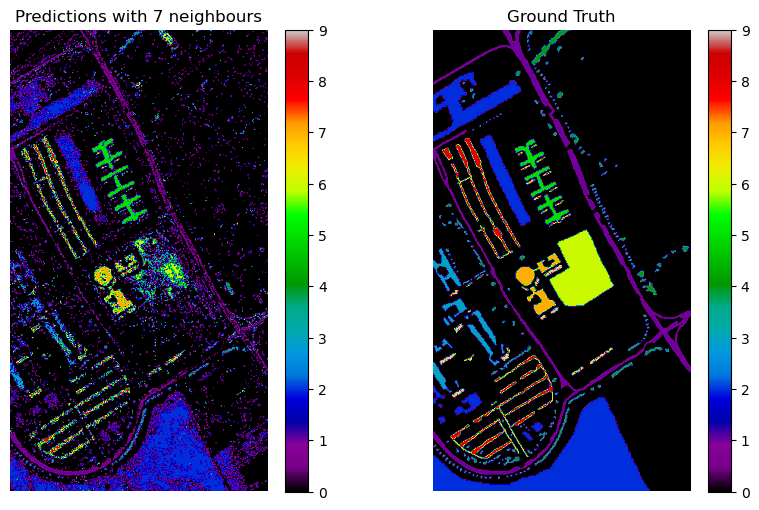

Classification Report with 7 neighbours:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92    164624
           1       0.72      0.48      0.58      6631
           2       0.73      0.71      0.72     18649
           3       0.73      0.48      0.58      2099
           4       0.73      0.29      0.42      3064
           5       0.85      0.91      0.88      1345
           6       0.70      0.29      0.41      5029
           7       0.70      0.75      0.72      1330
           8       0.66      0.54      0.59      3682
           9       0.70      0.46      0.55       947

    accuracy                           0.87    207400
   macro avg       0.74      0.59      0.64    207400
weighted avg       0.86      0.87      0.86    207400



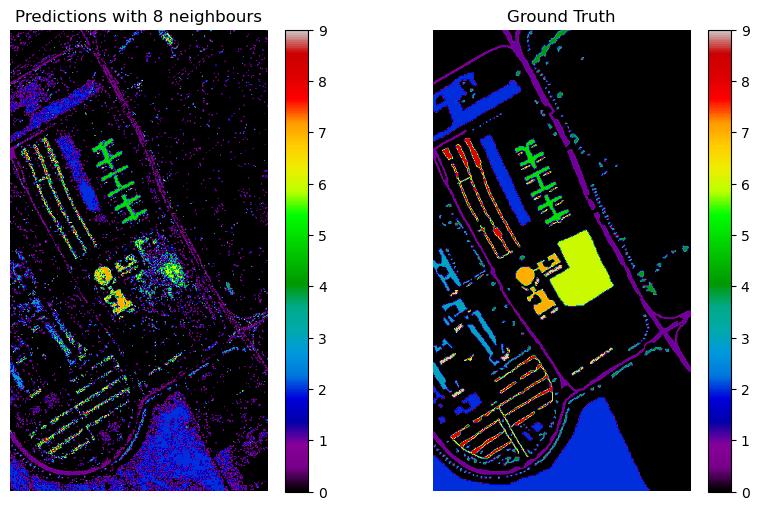

Classification Report with 8 neighbours:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92    164624
           1       0.74      0.39      0.51      6631
           2       0.76      0.64      0.70     18649
           3       0.72      0.43      0.54      2099
           4       0.78      0.21      0.33      3064
           5       0.86      0.88      0.87      1345
           6       0.76      0.23      0.36      5029
           7       0.72      0.72      0.72      1330
           8       0.68      0.46      0.55      3682
           9       0.71      0.29      0.41       947

    accuracy                           0.87    207400
   macro avg       0.76      0.52      0.59    207400
weighted avg       0.86      0.87      0.85    207400



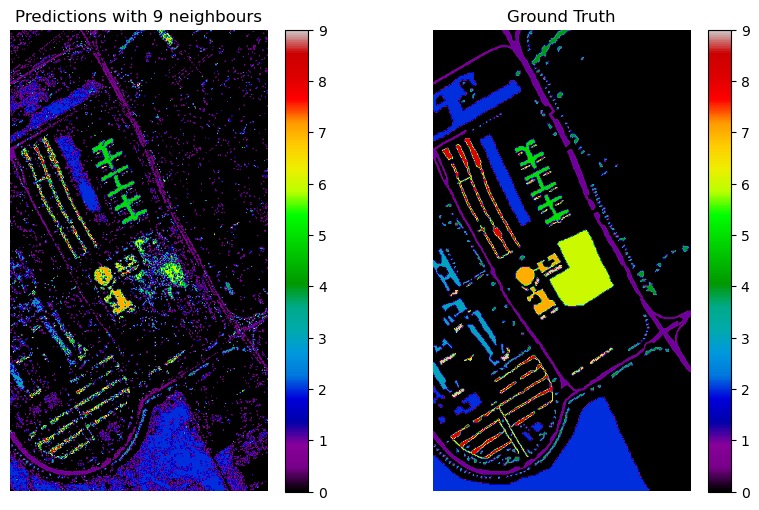

Classification Report with 9 neighbours:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    164624
           1       0.71      0.44      0.55      6631
           2       0.73      0.69      0.71     18649
           3       0.72      0.42      0.53      2099
           4       0.74      0.26      0.39      3064
           5       0.83      0.91      0.87      1345
           6       0.71      0.25      0.37      5029
           7       0.68      0.75      0.72      1330
           8       0.64      0.51      0.57      3682
           9       0.65      0.38      0.48       947

    accuracy                           0.86    207400
   macro avg       0.73      0.56      0.61    207400
weighted avg       0.86      0.86      0.85    207400



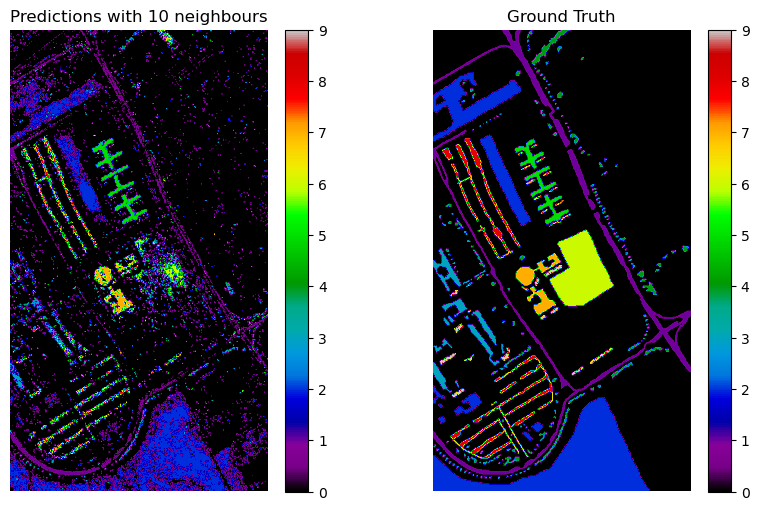

Classification Report with 10 neighbours:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92    164624
           1       0.74      0.38      0.50      6631
           2       0.74      0.64      0.69     18649
           3       0.73      0.41      0.52      2099
           4       0.78      0.20      0.32      3064
           5       0.85      0.89      0.87      1345
           6       0.73      0.21      0.33      5029
           7       0.69      0.73      0.71      1330
           8       0.64      0.45      0.53      3682
           9       0.68      0.26      0.37       947

    accuracy                           0.86    207400
   macro avg       0.75      0.51      0.58    207400
weighted avg       0.85      0.86      0.85    207400



In [389]:
l=[]
for i in range(1,11):
    l.append(knn(i))
    #print report for last pred
    print(f'Classification Report with {i} neighbours:\n{classification_report(df["class"], l[-1].ravel())}')

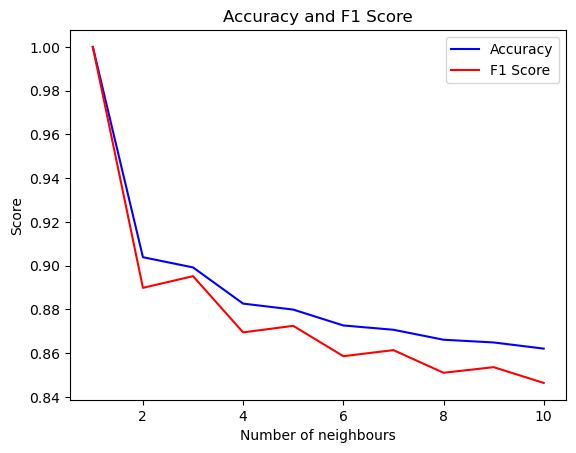

In [392]:
acc=[]
f=[]

for i in l:
    acc.append(accuracy_score(df["class"], i.ravel()))
    f.append(f1_score(df["class"], i.ravel(), average='weighted'))

#plot acc and f in the same plot

fig, ax = plt.subplots()
ax.plot(range(1,11), acc, 'b', label='Accuracy')
ax.plot(range(1,11), f, 'r', label='F1 Score')
ax.legend()
plt.xlabel('Number of neighbours')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score')
plt.show()

   

# Random Forest

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 450}
Best Score: 0.9281706995933433


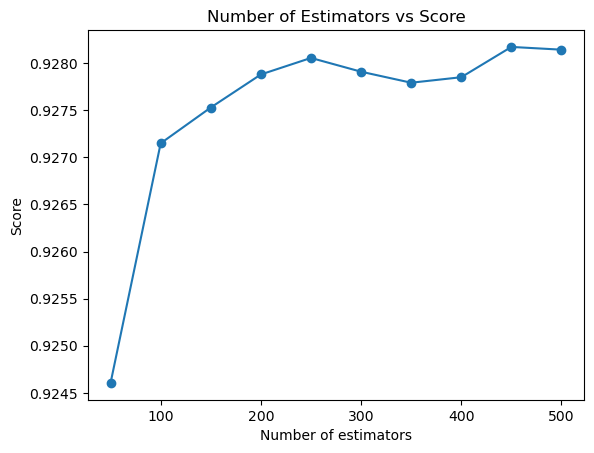

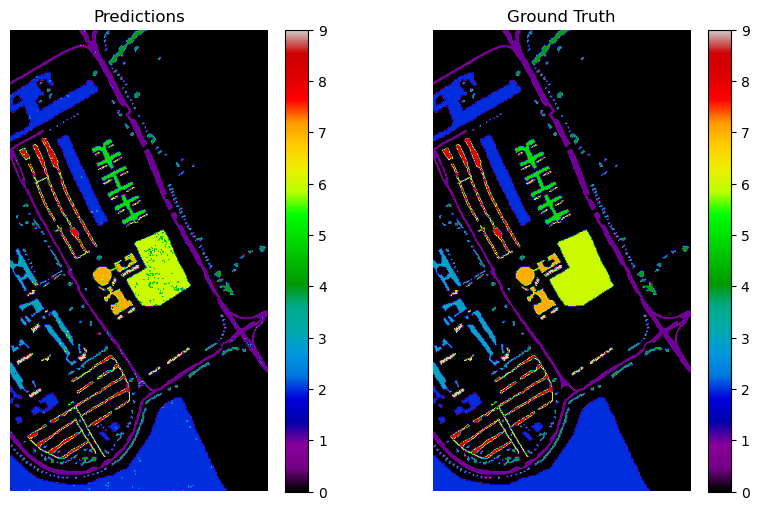

In [406]:
#test many number of estimators in the rf with grid search

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, np.argmax(y_train, axis=1))

best_model=grid_search.best_estimator_
#print best params and best score


print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

#plot the score for every model

scores = grid_search.cv_results_['mean_test_score']
estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

plt.plot(estimators, scores, marker='o', linestyle='-')

plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.title('Number of Estimators vs Score')

plt.show()

##plot predicted image and gt


imggg = best_model.predict(scaled_data)

imggg[mask] = 0

imggg = imggg.reshape(610, 340)

# Plot predictions and ground truth side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(imggg, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()



<Axes: >

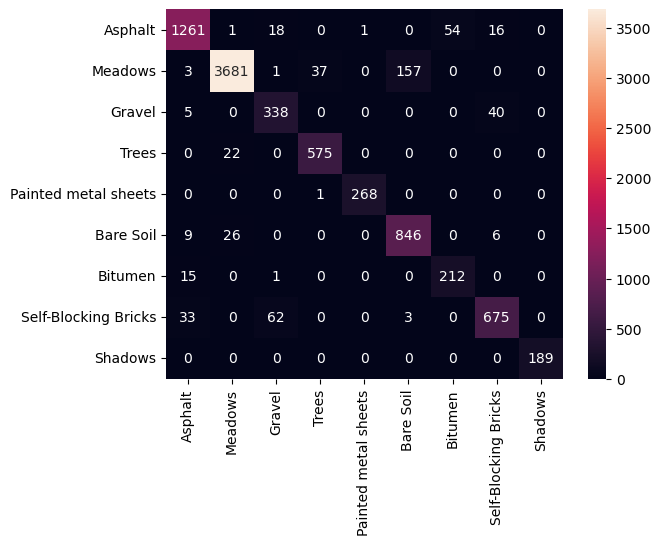

In [416]:
#confusion matrix

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(np.add(best_model.predict(X_test), 1), np.add(np.argmax(y_test, 1), 1))

classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

df_cm = pd.DataFrame(mat, index = classes, columns = classes)


sns.heatmap(df_cm, annot=True, fmt='d')



In [418]:
#confusion matrix on test set

print(classification_report(pred, np.argmax(y_test, 1), target_names = classes.append('Background')))


              precision    recall  f1-score   support

           1       0.95      0.93      0.94      1344
           2       0.99      0.95      0.97      3889
           3       0.81      0.87      0.84       392
           4       0.93      0.97      0.95       589
           5       1.00      1.00      1.00       269
           6       0.83      0.94      0.88       885
           7       0.80      0.91      0.85       232
           8       0.91      0.88      0.89       767
           9       1.00      1.00      1.00       189

    accuracy                           0.94      8556
   macro avg       0.91      0.94      0.92      8556
weighted avg       0.94      0.94      0.94      8556

